# Robyn: Marketing Mix Modeling in Python

Welcome to Robyn, a powerful Marketing Mix Modeling (MMM) tool developed by Meta. This notebook demonstrates how to use Robyn to build and analyze marketing mix models.

## Prerequisites

⚠️ **Important**: Before proceeding, please complete the setup steps in the [Python Robyn README](https://github.com/facebookexperimental/Robyn/blob/main/python/README.md). You'll need:
1. R installed with the `glmnet` package
2. Python virtual environment (recommended)
3. Robyn installed via pip or from source

This notebook demonstrates the basic workflow of using Robyn for Marketing Mix Modeling. For your own analysis:

1. Replace the sample data with your marketing data
2. Adjust the model parameters based on your business context
3. Validate results against your business knowledge 
4. Use the optimization insights to guide marketing budget allocation

For more information, visit the [Robyn documentation](https://github.com/facebookexperimental/Robyn).

## Setup Options

There are two ways to use this notebook:

### Option 1: Using the Published Package
If you're using the published `robynpy` package:

In [1]:
# %pip install robynpy==0.2.1

#### Loading Simulated Data with `robynpy` if you are running on Google Colab.

After installing the `robynpy` package using pip, you can load the simulated data by following these steps:


In [2]:
# # Step 1: Import Necessary Libraries
# import importlib
# import robyn
# import os
# import pandas as pd

# # Step 2: Load the `robyn` Package
# pkg = importlib.import_module("robyn")

# # Step 3: Define the Path to Tutorials
# tutorials_path = pkg.__path__[0] + "/tutorials"

# # Step 4: Load and Display Simulated Weekly Data
# dt_simulated_weekly = pd.read_csv(tutorials_path + "/resources/dt_simulated_weekly.csv")
# print("Simulated Data...")
# print(dt_simulated_weekly.head())

# # Step 5: Load and Display Prophet Holidays Data
# dt_prophet_holidays = pd.read_csv(tutorials_path + "/resources/dt_prophet_holidays.csv")
# print("Holidays Data...")
# print(dt_prophet_holidays.head())

### Option 2: Using the Development Version
If you're working with the source code, add the source directory to Python path:

In [3]:
import sys
import os

notebook_path = os.path.abspath("")
robyn_path = os.path.abspath(os.path.join(notebook_path, "../../"))
if robyn_path not in sys.path:
    sys.path.append(robyn_path)

#### Configure Logging for the Development Version

This section sets up logging for the Robyn analysis in the development version. The logger will:
- Create a `logs` directory in your current working directory
- Generate timestamped log files (e.g., `robynpy_20250317_105359.log`)
- Record detailed execution information and any warnings/errors

The logs can be helpful for:
- Debugging issues
- Tracking model execution progress
- Auditing parameter choices and results
- Understanding warning messages

You can find the log files in the `./logs` directory after running the notebook.

In [4]:
# ## Configure Logging
# import os
# import logging.config
# from datetime import datetime

# # Create log directory if it doesn't exist
# log_dir = os.path.join(os.getcwd(), "logs")  # Use relative path in current directory
# os.makedirs(log_dir, exist_ok=True)

# # Generate a unique log file name using the current date and time
# log_file_name = f"robynpy_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
# log_file_path = os.path.join(log_dir, log_file_name)

# # Get the package directory for the logging config
# import robyn

# robyn_pkg_dir = os.path.dirname(robyn.__file__)
# logging_conf_path = os.path.join(robyn_pkg_dir, "common", "config", "logging.conf")

# # Load the logging configuration with the dynamic log file name
# logging.config.fileConfig(
#     logging_conf_path,
#     defaults={"logfilename": log_file_path},
# )

# logger = logging.getLogger(__name__)
# logger.info("Logging initialized - check log directory for detailed logs")

## Loading Simulated Data from Local Build

[Running locally] For this demonstration, we'll use simulated data from our local build.

In [5]:
import pandas as pd

# Load simulated weekly data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

# Load holidays data (used for seasonality modeling)
dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

In [6]:
import pandas as pd

from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2025-03-26 13:59:29,062 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/Robyn/.pyvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Required Libraries

We'll import the core components directly from Robyn's source:

## Configure MMM Data

Define the model specification including dependent variables, independent variables, and analysis window. Here's what each parameter means:

### Key Components:
- `dep_var`: Your target metric (e.g., "revenue", "conversions")
- `dep_var_type`: Type of dependent variable ("revenue" for ROI or "conversion" for CPA)
- `date_var`: Column name containing dates
- `window_start/end`: Analysis time period

### Variable Types:
- `paid_media_spends`: Columns containing media spend data (e.g., TV, Facebook, Search)
- `paid_media_vars`: Media exposure metrics (impressions, clicks) in same order as spends
- `context_vars`: External factors (e.g., competitor activities, events, seasonality)
- `organic_vars`: Marketing activities without direct spend (e.g., email, social posts)

Example configuration:

In [7]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        factor_vars=["events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Configure Hyperparameters

Hyperparameters control how media effects are modeled. Each channel requires three key parameters:

### Media Channel Parameters:
- `alphas`: Controls saturation curve shape [0.5, 3]
  - Lower values (0.5-1): More diminishing returns
  - Higher values (2-3): More S-shaped response
  
- `gammas`: Controls saturation curve inflection point [0.3, 1]
  - Lower values: Earlier diminishing returns
  - Higher values: Later diminishing returns

- `thetas`: Controls adstock decay rate [0, 0.8]
  - Lower values (0-0.2): Fast decay (e.g., Search, Social)
  - Medium values (0.1-0.4): Medium decay (e.g., Print, OOH)
  - Higher values (0.3-0.8): Slow decay (e.g., TV)

### Global Parameters:
- `adstock`: Type of carryover effect modeling
  - "geometric": Fixed decay rate
  - "weibull_cdf": Flexible decay with cumulative distribution
  - "weibull_pdf": Flexible decay with potential peak delay

- `lambda_`: Ridge regression regularization [0, 1]
- `train_size`: Proportion of data for training [0.5, 0.8]

In [8]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


## Configure Holiday Data

Holiday data helps capture seasonality and special events in your model. The HolidaysData configuration includes:

### Components:
- `dt_holidays`: DataFrame containing holiday/events data
- `prophet_vars`: Time components to model:
  - "trend": Long-term trend
  - "season": Seasonal patterns
  - "holiday": Holiday/event effects
- `prophet_country`: Country code for built-in holidays (e.g., "DE" for Germany)
- `prophet_signs`: Effect direction for each prophet_var:
  - "default": Let the model determine direction
  - "positive": Force positive effect
  - "negative": Force negative effect

Note: You can add custom events (school breaks, promotional periods, etc.) to the holidays data.

In [9]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

## Feature Engineering Process

The feature engineering step prepares raw marketing data for modeling through four main steps:

### 1. Data Preprocessing
- Standardizes dates and variables
- Applies analysis time window
- Handles missing values and data types

### 2. Time Series Decomposition
Uses Prophet to decompose data into:
- Trend and seasonality components
- Holiday and event effects
- Monthly/weekly patterns

### 3. Media Variable Processing
For channels with different spend vs. exposure metrics:
- Fits and compares linear and non-linear models
- Selects best model based on fit metrics
- Generates spend-exposure relationship plots

### 4. Marketing Effect Transformations
Applies marketing-specific adjustments:
- Adstock transformation for carryover effects
- Saturation curves for diminishing returns
- Media cost factor normalization

The output is a FeaturizedMMMData object containing the transformed features ready for modeling.

In [10]:
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

featurized_mmm_data = feature_engineering.perform_feature_engineering()

2025-03-26 13:59:35,714 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2025-03-26 13:59:35,716 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2025-03-26 13:59:35,717 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/Robyn/.pyvenv/lib/python3.12/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2025-03-26 13:59:36,454 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpetvfxfl4/hgzfcz6b.json
2025-03-26 13:59:36,463 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr

## Visualize Feature Relationships

Plot the spend-exposure relationships for each channel to understand how media spend translates to exposure metrics. These plots show:
- How media spend relates to exposure (impressions, clicks, etc.)
- Model fit quality (R² value)
- Whether the relationship follows linear or Michaelis-Menten patterns

2025-03-26 13:59:36,718 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2025-03-26 13:59:36,718 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2025-03-26 13:59:36,718 - robyn.visualization.feature_visualization - INFO - Found result for channel facebook_I
2025-03-26 13:59:36,868 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


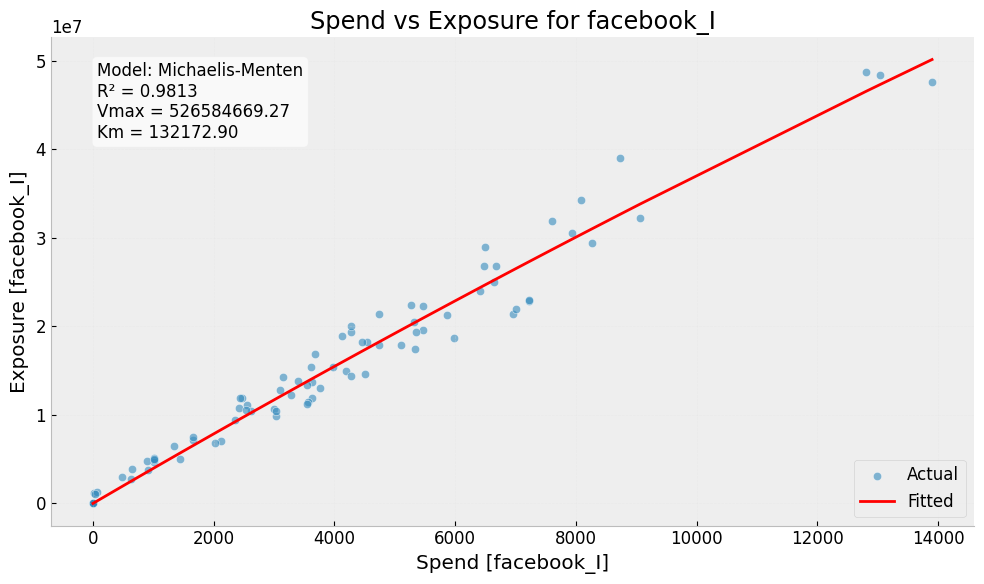

2025-03-26 13:59:37,008 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2025-03-26 13:59:37,011 - robyn.visualization.feature_visualization - INFO - Found result for channel search_clicks_P
2025-03-26 13:59:37,167 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


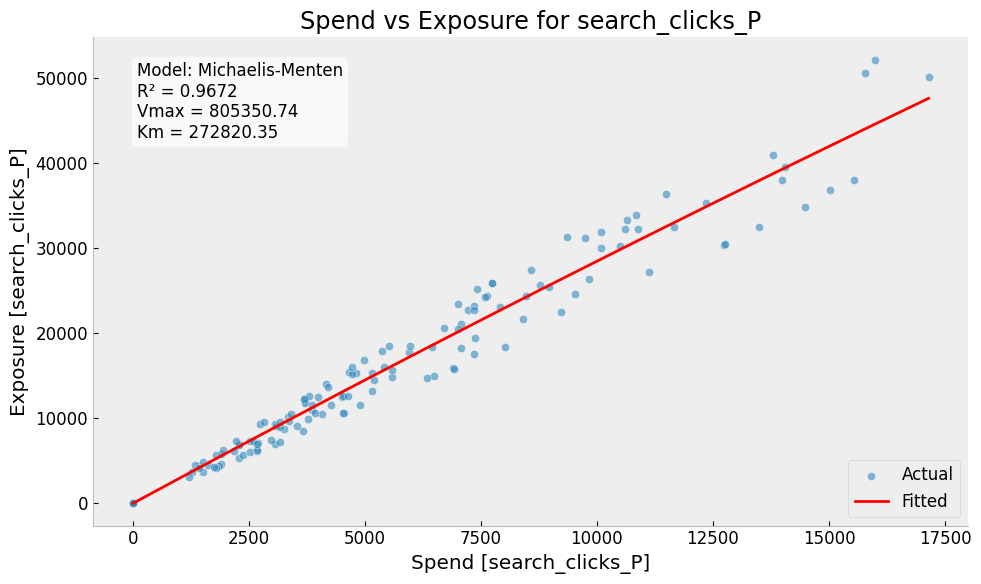

In [11]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create plotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmm_data)
results_list = featurized_mmm_data.modNLS["results"]

# Plot each channel
for result in results_list:
    channel = result["channel"]
    try:
        # Get the figure dictionary
        fig_dict = feature_plotter.plot_spend_exposure(channel)
        
        if "spend-exposure" in fig_dict:
            fig = fig_dict["spend-exposure"]
            # Need to get the axis from the figure
            ax = fig.get_axes()[0]
            # Draw the figure to make sure it's rendered
            fig.canvas.draw()
            # Display using display instead of show
            from IPython.display import display
            display(fig)
            
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")
    except Exception as e:
        print(f"Error plotting {channel}: {str(e)}")

## Model Training

### Training Configuration:
- `trials`: Number of parallel optimization trials (e.g., 5)
- `iterations`: Optimization iterations per trial (e.g., 2000)
- `ts_validation`: Whether to use time-series validation
- `cores`: Number of CPU cores to use for parallel processing
- `nevergrad_algo`: Optimization algorithm (TWO_POINTS_DE recommended)
- `model_name`: Model type (RIDGE regression recommended)

Parameters:
- `add_penalty_factor`: Additional regularization for stability
- `rssd_zero_penalty`: Penalize unrealistic zero contributions
- `intercept`: Include intercept term
- `intercept_sign`: Control intercept direction

Note: More iterations and trials generally lead to better results but increase computation time.

In [12]:
plt.ioff()
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,
    featurized_mmm_data=featurized_mmm_data,
)

trials_config = TrialsConfig(iterations=50, trials=5)

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
plt.close()

2025-03-26 13:59:37,253 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2025-03-26 13:59:37,254 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2025-03-26 13:59:37,255 - robyn.modeling.base_model_executor - INFO - Input validation successful
2025-03-26 13:59:37,255 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2025-03-26 13:59:37,255 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2025-03-26 13:59:37,256 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2025-03-26 13:59:37,259 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2025-03-26 13:59:37,259 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of 5:   0%|          | 0/2000 [00:00<?, ?it/s]2025-03-26 13:59:37,375 - rpy2.situation - INFO - cffi mod

## Model Convergence Analysis

After training the models, we can examine two key visualization plots that help assess model convergence and optimization quality:

### MOO Cloud Plot
This plot shows the distribution of model solutions in the objective space:
- X-axis: Model fit error (NRMSE) - lower is better
- Y-axis: Decomposition error - lower is better


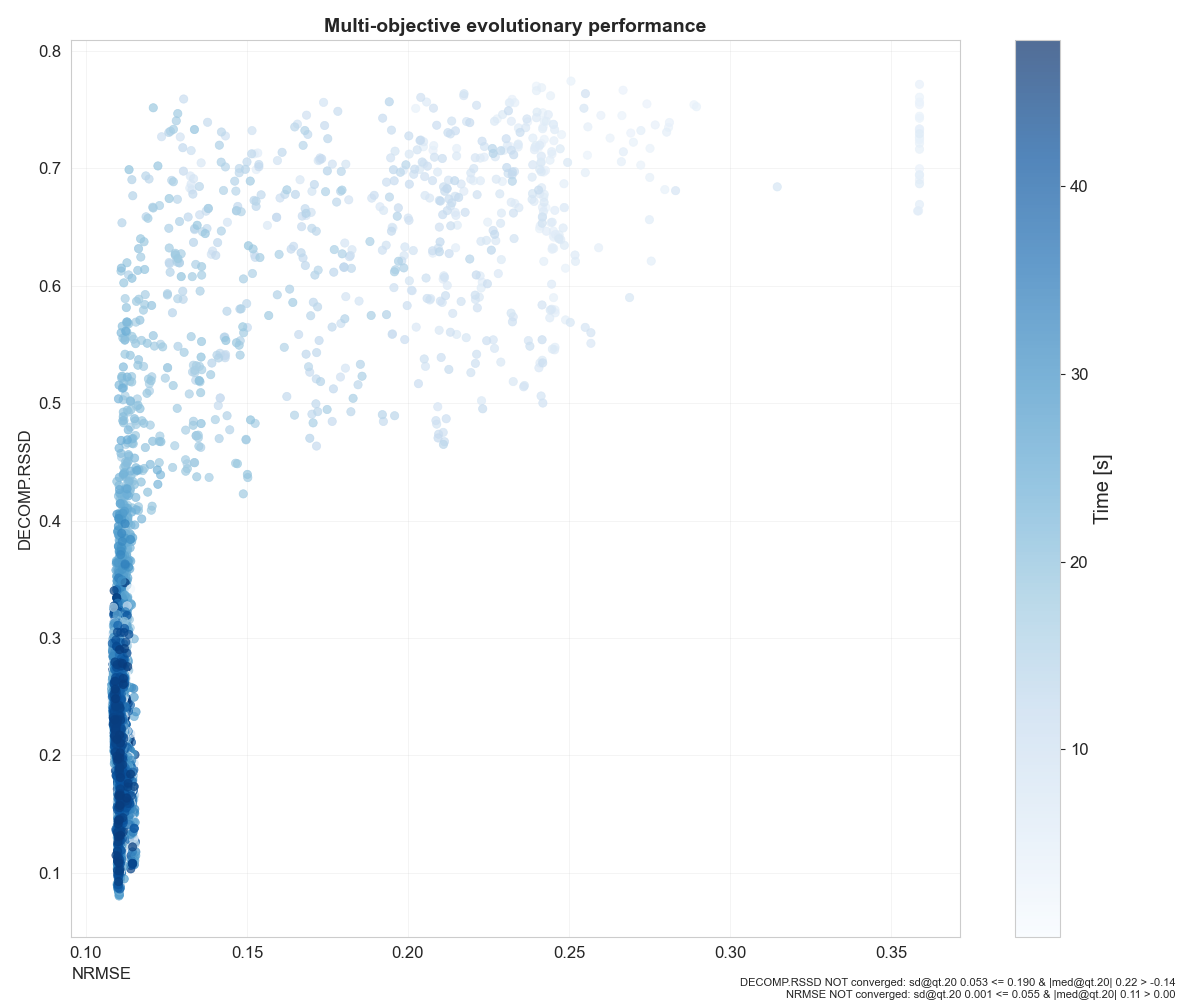

In [13]:
from IPython.display import Image, display
import base64

# Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    moo_cloud_plot = output_models.convergence["moo_cloud_plot"]
    display(Image(data=base64.b64decode(moo_cloud_plot)))

### MOO Distribution Plot 
This plot shows the distribution of objective values across all trials:
- Shows the spread of NRMSE and decomposition errors
- Helps identify if optimization has converged to stable solutions
- Wide distributions may indicate need for more iterations
- Narrow distributions suggest consistent model performance

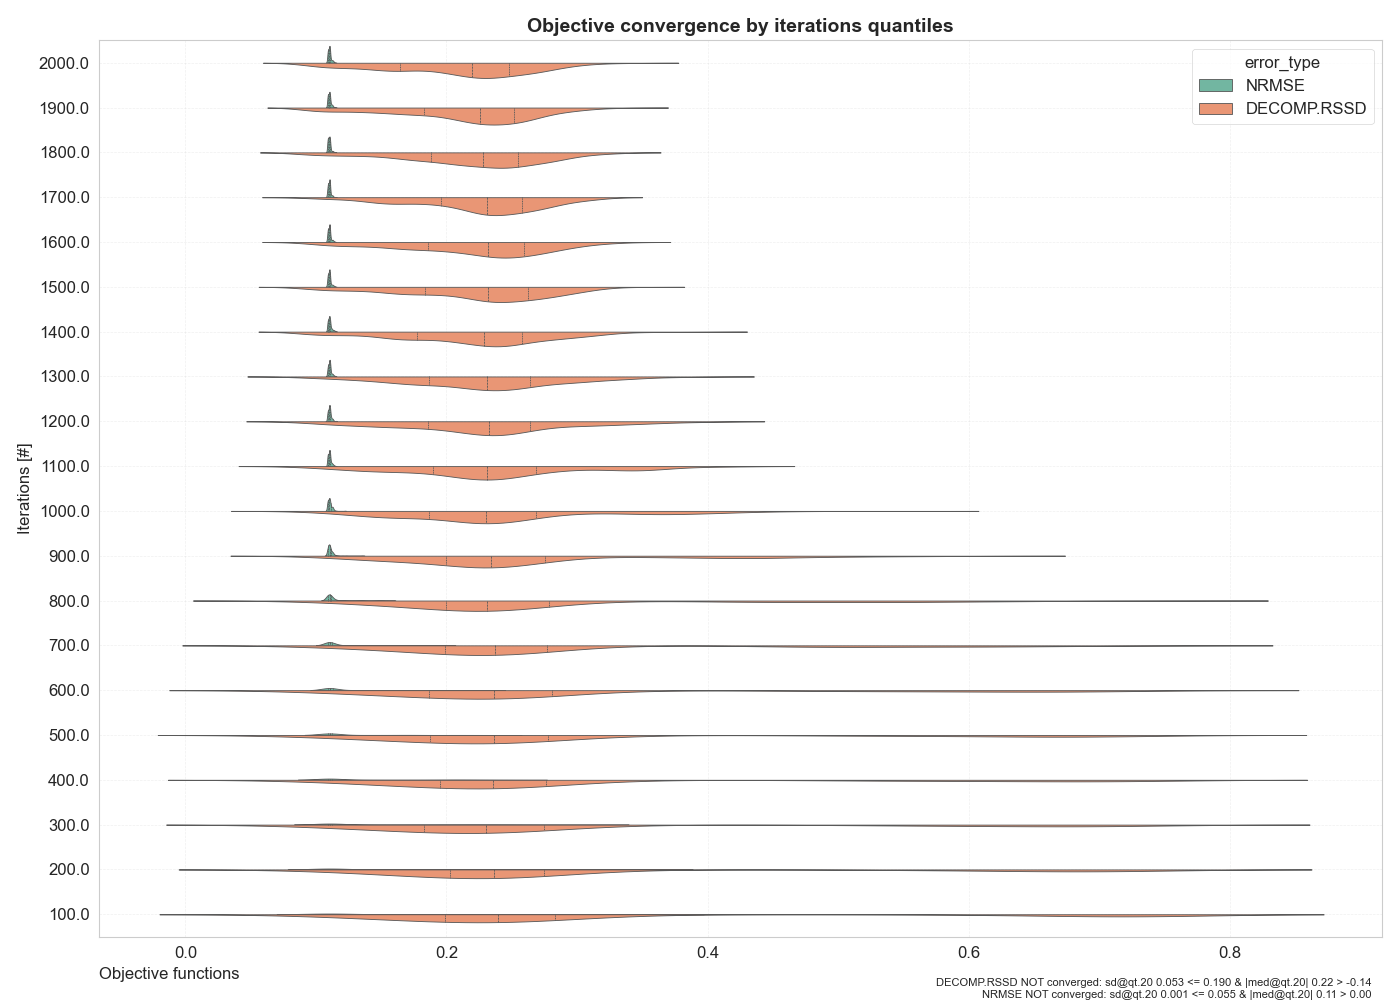

In [14]:
# Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    moo_distrb_plot = output_models.convergence["moo_distrb_plot"]
    display(Image(data=base64.b64decode(moo_distrb_plot)))

## Model Selection and Clustering

### 1. Pareto Optimization
Pareto optimization helps select the best models by balancing multiple objectives:
- Model accuracy (NRMSE)
- Decomposition accuracy
- Model robustness

Parameters:
- `pareto_fronts`: Number of Pareto fronts to consider ("auto" recommended)
- `min_candidates`: Minimum number of models to retain (e.g., 100)

In [15]:
print("\n=== Starting Data Comparison ===")

# 1. Hyperparameters for facebook_S and search_S
print("\n1. Hyperparameters:")
for channel in ["facebook_S", "search_S"]:
    params = output_models.all_result_hyp_param[
        [f"{channel}_alphas", f"{channel}_gammas", f"{channel}_thetas", "sol_id"]
    ].head(5)
    print(f"\n{channel} parameters:")
    print(params)

# 2. Raw coefficients and decomposition values
print("\n2. Raw Model Outputs:")
fb_search_decomp = output_models.all_x_decomp_agg[
    output_models.all_x_decomp_agg["rn"].isin(["facebook_S", "search_S"])
]
print("\nFirst 5 solutions for each channel:")
print(fb_search_decomp[["sol_id", "rn", "coef", "xDecompAgg"]].head(10))

# 3. Mean values used for points on the curve
print("\n3. Mean Values:")
mean_values = output_models.all_decomp_spend_dist[
    output_models.all_decomp_spend_dist["rn"].isin(["facebook_S", "search_S"])
]
print("\nMean spend and response values:")
print(mean_values[["sol_id", "rn", "mean_spend"]].head(10))


=== Starting Data Comparison ===

1. Hyperparameters:

facebook_S parameters:
   facebook_S_alphas  facebook_S_gammas  facebook_S_thetas sol_id
0           1.398657           0.820062           0.076239  1_1_1
1           2.071251           0.750268           0.054361  1_2_1
2           2.275836           0.779594           0.123212  1_3_1
3           1.585355           0.656802           0.166792  1_4_1
4           2.074253           0.533381           0.086978  1_5_1

search_S parameters:
   search_S_alphas  search_S_gammas  search_S_thetas sol_id
0         1.702513         0.808199         0.132769  1_1_1
1         1.557482         0.525760         0.120453  1_2_1
2         1.309544         0.667145         0.128105  1_3_1
3         1.642872         0.687378         0.168529  1_4_1
4         1.201476         0.593221         0.142671  1_5_1

2. Raw Model Outputs:

First 5 solutions for each channel:
   sol_id          rn           coef    xDecompAgg
9   1_1_1  facebook_S   73769.54

In [16]:
print("\n=== Key Data Before Pareto ===")

# 1. Model parameters and metrics
print("\n1. all_result_hyp_param:")
print("Shape:", output_models.all_result_hyp_param.shape)
print("\nColumns:", output_models.all_result_hyp_param.columns.tolist())
print("\nSample rows with key metrics:")
print(
    output_models.all_result_hyp_param[
        ["sol_id", "nrmse", "decomp.rssd", "mape"]
    ].head()
)

# 2. Decomposition results for media channels
print("\n2. all_x_decomp_agg:")
print("Shape:", output_models.all_x_decomp_agg.shape)
print("\nColumns:", output_models.all_x_decomp_agg.columns.tolist())
media_decomp = output_models.all_x_decomp_agg[
    output_models.all_x_decomp_agg["rn"].isin(mmm_data.mmmdata_spec.paid_media_spends)
]
print("\nSample rows:")
print(media_decomp[["sol_id", "rn", "coef", "xDecompAgg"]].head())
print("\nValue ranges for media channels:")
print(media_decomp[["coef", "xDecompAgg"]].describe())

# 3. Spend distribution
print("\n3. all_decomp_spend_dist:")
print("Shape:", output_models.all_decomp_spend_dist.shape)
print("\nColumns:", output_models.all_decomp_spend_dist.columns.tolist())
print("\nSample rows:")
print(
    output_models.all_decomp_spend_dist[
        ["sol_id", "rn", "xDecompAgg", "xDecompPerc"]
    ].head()
)

# 4. Check a specific solution's media values
sample_sol = media_decomp["sol_id"].iloc[0]
print(f"\n4. Detailed check for solution {sample_sol}:")
print("\nMedia channel values:")
print(media_decomp[media_decomp["sol_id"] == sample_sol][["rn", "coef", "xDecompAgg"]])


=== Key Data Before Pareto ===

1. all_result_hyp_param:
Shape: (10000, 39)

Columns: ['facebook_S_alphas', 'facebook_S_gammas', 'facebook_S_thetas', 'newsletter_alphas', 'newsletter_gammas', 'newsletter_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'ooh_S_thetas', 'print_S_alphas', 'print_S_gammas', 'print_S_thetas', 'search_S_alphas', 'search_S_gammas', 'search_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'tv_S_thetas', 'lambda', 'train_size', 'lower_limits', 'upper_limits', 'sol_id', 'ElapsedAccum', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd', 'mape', 'lambda_hp', 'lambda_max', 'lambda_min_ratio', 'iterNG', 'iterPar']

Sample rows with key metrics:
  sol_id     nrmse  decomp.rssd  mape
0  1_1_1  0.425145     0.742662     0
1  1_2_1  0.392529     0.744375     0
2  1_3_1  0.255750     0.711163     0
3  1_4_1  0.242858     0.666481     0
4  1_5_1  0.373247     0.756356     0

2. all_x_decomp_agg:
Shape: (120000, 30)

Columns: ['

In [17]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer

# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(
    mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data
)

# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2025-03-26 14:03:34 [INFO] Starting Pareto optimization
2025-03-26 14:03:34,060 - robyn.modeling.pareto.data_aggregator - INFO - Starting model data aggregation
2025-03-26 14:03:34 [INFO] Computing Pareto fronts
2025-03-26 14:03:34 [INFO] Pareto front computation completed
2025-03-26 14:03:34 [INFO] Preparing Pareto data
2025-03-26 14:03:34 [INFO] Number of Pareto-optimal solutions found: 8802
2025-03-26 14:03:34 [INFO] Selected 3 Pareto-fronts containing 114 candidates
2025-03-26 14:03:34 [INFO] Selected Pareto fronts: 4
2025-03-26 14:03:34 [INFO] Filtering data for selected Pareto fronts...
2025-03-26 14:03:34 [INFO] Pareto data preparation completed
2025-03-26 14:03:34,634 - robyn.modeling.pareto.response_curve - INFO - Calculating response curves for 570 models' media variables...
Processing rows: 100%|██████████| 570/570 [00:05<00:00, 103.87it/s]
2025-03-26 14:03:40,854 - robyn.modeling.pareto.response_curve - INFO - Successfully processed 570 response curves
2025-03-26 14:03:40,8

### 2. Model Clustering
Clustering groups similar models together to identify stable solutions.

Configuration parameters:
- `dep_var_type`: Type of dependent variable (revenue/conversion)
- `cluster_by`: Clustering criterion (HYPERPARAMETERS recommended)
- `max_clusters`: Maximum number of clusters to consider
- `min_clusters`: Minimum number of clusters
- `weights`: Importance weights for clustering criteria

In [18]:
from robyn.modeling.clustering.clustering_config import ClusteringConfig, ClusterBy
from robyn.modeling.clustering.cluster_builder import ClusterBuilder
from robyn.data.entities.enums import DependentVarType
import plotly.io as pio

pio.renderers.default = "iframe"

cluster_configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    max_clusters=10,
    min_clusters=3,
    weights=[1.0, 1.0, 1.0],
)

cluster_builder = ClusterBuilder(pareto_result=pareto_result)


cluster_results = cluster_builder.cluster_models(cluster_configs)

2025-03-26 14:03:53,428 - robyn.modeling.clustering.cluster_builder - INFO - Initializing ClusterBuilder
2025-03-26 14:03:53,428 - robyn.modeling.clustering.cluster_builder - INFO - ClusterBuilder initialization complete
2025-03-26 14:03:53,429 - robyn.modeling.clustering.cluster_builder - INFO - Starting model clustering process
2025-03-26 14:03:53,434 - robyn.modeling.clustering.cluster_builder - INFO - Auto-detected media channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
2025-03-26 14:03:53,434 - robyn.modeling.clustering.cluster_builder - INFO - Clustering by: ClusterBy.HYPERPARAMETERS
2025-03-26 14:03:53,436 - robyn.modeling.clustering.cluster_builder - INFO - Starting optimal cluster selection
2025-03-26 14:03:53,436 - robyn.modeling.clustering.cluster_builder - INFO - Ignored features: decomp.rssd, pareto, nrmse_val, nrmse, nrmse_test, mape, sol_id, nrmse_train
2025-03-26 14:03:53,437 - robyn.modeling.clustering.cluster_builder - INFO - Starting WSS 

## Reestablish Pareto Results

In [19]:
from robyn.modeling.pareto.pareto_utils import ParetoUtils

utils = ParetoUtils()
pareto_result = utils.process_pareto_clustered_results(
    pareto_result,
    clustered_result=cluster_results,
    ran_cluster=True,
    ran_calibration=False,
)

## Budget Allocation Optimization

Robyn provides different scenarios for budget allocation optimization. Let's explore the "max_response" scenario:

### Scenario: Maximum Response
This scenario answers the question: "What's the maximum return given certain spend constraints?"

Key parameters:
- `total_budget`: When set to None, uses the total spend in the selected date range
- `channel_constr_low`: Minimum spend multiplier (e.g., 0.7 means channel spend can't go below 70% of current)
- `channel_constr_up`: Maximum spend multiplier per channel (e.g., 1.5 means channel spend can't exceed 150% of current)
- `channel_constr_multiplier`: Extends bounds for wider optimization insights
- `date_range`: Period for optimization ("all", "last_X", or specific date range)

Note: Other scenarios include:
- "target_efficiency": Optimize spend to hit specific ROAS or CPA targets
- "min_spend": Find minimum spend required to hit response targets
- "max_response_expected": Maximize expected response within confidence intervals

For this example, we'll demonstrate the "max_response" scenario:

In [20]:
select_model = pareto_result.pareto_solutions[0]

print(select_model)

5_1227_1


In [21]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator.entities.optimization_result import OptimizationResult
from robyn.allocator.entities.constraints import Constraints
from robyn.allocator.optimizer import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    CONSTRAINT_MODE_EQ,
)


# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=pareto_result,
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
max_response_result = max_response_allocator.optimize()

## Analyze Results

Create summary of optimization results:

In [22]:
import numpy as np

results_df = pd.DataFrame(
    {
        "Channel": max_response_result.dt_optimOut.channels,
        "Initial Spend": max_response_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": max_response_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            max_response_result.dt_optimOut.optm_spend_unit
            / max_response_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": max_response_result.dt_optimOut.init_response_unit,
        "Optimized Response": max_response_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            max_response_result.dt_optimOut.optm_response_unit
            / max_response_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print(results_df.round(2))

      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26         11397.58          -30.00   
1       ooh_S       52818.55         53867.80            1.99   
2     print_S        3856.63          5784.95           50.00   
3  facebook_S        2141.53          1499.07          -30.00   
4    search_S        5099.15          7648.72           50.00   

   Initial Response  Optimized Response  Response Lift %  
0           1042.90              366.46           -64.86  
1         100013.45           100647.44             0.63  
2           4103.30            11316.92           175.80  
3             24.22                8.99           -62.89  
4          10548.25            13692.79            29.81  


## Budget Allocation Visualization Results

The allocator generates two key plots to visualize optimization results:

### 1. Budget Comparison Plot (`_plot_budget_comparison`)
This plot shows a comparison between three scenarios: Initial, Bounded, and Bounded x3:
- Bar pairs showing total spend vs total response for each scenario
- Each scenario includes metrics text showing:
  - For Initial: Spend, Response, and ROAS/CPA
  - For others: Percent changes in Spend and Response, plus ROAS/CPA
- Color-coded bars (Silver for Initial, Steel Blue for Bounded, Golden Rod for Bounded x3)
- Values scaled up to represent the full analysis period

### 2. Allocation Matrix Plot (`_plot_allocation_matrix`)
Shows three side-by-side heatmaps comparing allocation strategies:
- Columns in each heatmap represent:
  - Absolute mean spend (in thousands)
  - Mean spend percentage
  - Mean response percentage
  - Mean ROAS/CPA
  - Marginal ROAS/CPA
- Each row represents a different paid media channel
- Color intensity indicates relative values within each scenario
- Different color schemes for each scenario:
  - Initial: Grey scale
  - Bounded: Blue scale
  - Bounded x3: Yellow/Gold scale

In [23]:
cluster_results.top_solutions

,cluster,rank,sol_id,facebook_S_alphas,facebook_S_gammas,facebook_S_thetas,newsletter_alphas,newsletter_gammas,newsletter_thetas,ooh_S_alphas,...,tv_S_thetas,nrmse,nrmse_train,nrmse_val,nrmse_test,decomp.rssd,mape,mape.qt10,n,error_score
8651,0,1.0,5_652_1,2.983274,0.976528,0.012500,0.625067,0.328095,0.378912,0.512979,...,0.508646,0.108744,0.056963,0.108744,0.061737,0.223321,0.0,True,44,0.358576
5191,1,1.0,3_1192_1,2.780430,0.716672,0.012868,1.218220,0.415139,0.395949,0.516039,...,0.548629,0.110220,0.058290,0.110220,0.044947,0.084429,0.0,True,35,0.023784
8545,2,1.0,5_546_1,2.876706,0.957260,0.011109,0.712372,0.353978,0.397699,0.500773,...,0.537313,0.109406,0.055499,0.109406,0.055556,0.188902,0.0,True,27,0.258170
9166,3,1.0,5_1167_1,2.783909,0.778254,0.001058,1.157278,0.549680,0.389862,0.517780,...,0.440993,0.109779,0.058015,0.109779,0.046184,0.129864,0.0,True,8,0.100585


2025-03-26 14:03:56,136 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2025-03-26 14:03:56,137 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 5_1227_1
2025-03-26 14:03:56,137 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2025-03-26 14:03:56,170 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot


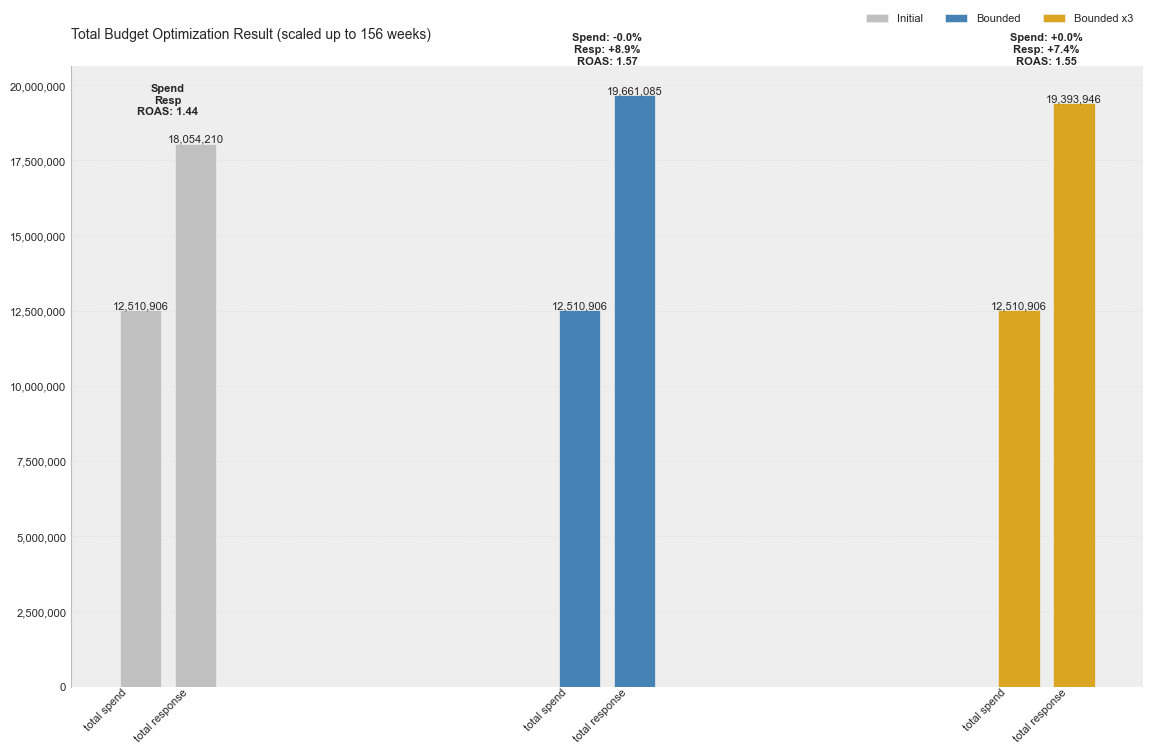

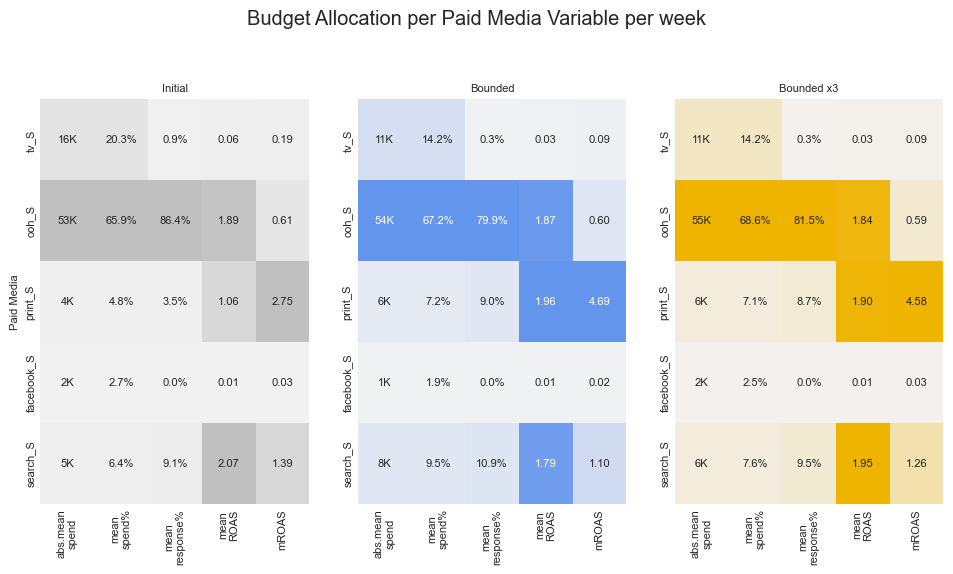

In [24]:
from robyn.visualization.allocator_visualizer import AllocatorPlotter

plotter = AllocatorPlotter(
    allocation_result=max_response_result, budget_allocator=max_response_allocator
)

plots = plotter.plot_all(display_plots=True, export_location=None)

In [25]:
cluster_results.top_solutions

,cluster,rank,sol_id,facebook_S_alphas,facebook_S_gammas,facebook_S_thetas,newsletter_alphas,newsletter_gammas,newsletter_thetas,ooh_S_alphas,...,tv_S_thetas,nrmse,nrmse_train,nrmse_val,nrmse_test,decomp.rssd,mape,mape.qt10,n,error_score
8651,0,1.0,5_652_1,2.983274,0.976528,0.012500,0.625067,0.328095,0.378912,0.512979,...,0.508646,0.108744,0.056963,0.108744,0.061737,0.223321,0.0,True,44,0.358576
5191,1,1.0,3_1192_1,2.780430,0.716672,0.012868,1.218220,0.415139,0.395949,0.516039,...,0.548629,0.110220,0.058290,0.110220,0.044947,0.084429,0.0,True,35,0.023784
8545,2,1.0,5_546_1,2.876706,0.957260,0.011109,0.712372,0.353978,0.397699,0.500773,...,0.537313,0.109406,0.055499,0.109406,0.055556,0.188902,0.0,True,27,0.258170
9166,3,1.0,5_1167_1,2.783909,0.778254,0.001058,1.157278,0.549680,0.389862,0.517780,...,0.440993,0.109779,0.058015,0.109779,0.046184,0.129864,0.0,True,8,0.100585


In [26]:
# Add these debug lines before calling generate_one_pager
print("Available columns:", pareto_result.x_decomp_agg.columns)
print("First few rows:", pareto_result.x_decomp_agg.head())

Available columns: Index(['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0',
       'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF',
       'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'train_size',
       'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train', 'nrmse_val',
       'nrmse_test', 'nrmse', 'decomp.rssd', 'mape', 'lambda', 'lambda_hp',
       'lambda_max', 'lambda_min_ratio', 'solID', 'trial', 'iterNG', 'iterPar',
       'Elapsed', 'iterations', 'robynPareto', 'total_spend', 'mean_spend',
       'mean_spend_adstocked', 'mean_carryover', 'mean_response',
       'spend_share', 'effect_share', 'roi_mean', 'roi_total', 'cpa_total',
       'cluster', 'top_sol', 'boot_mean', 'boot_se', 'ci_low', 'ci_up',
       'carryover_pct'],
      dtype='object')
First few rows:                    rn           coef    xDecompAgg  xDecompPerc  \
0           intercept  429877.253545  6.749073e+07     0.232404   
1               trend       0.036652  1.025543e+07     0.0353

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        936 non-null    datetime64[ns]
 1   channel   936 non-null    object        
 2   response  936 non-null    float64       
 3   spend     936 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 29.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5 non-null      int64  
 1   channel               5 non-null      object 
 2   mean_spend            5 non-null      float64
 3   mean_spend_adstocked  5 non-null      float64
 4   mean_carryover        5 non-null      float64
 5   mean_response         5 non-null      float64
 6   sol_id                5 non-null   

[<Figure size 2000x4000 with 8 Axes>]

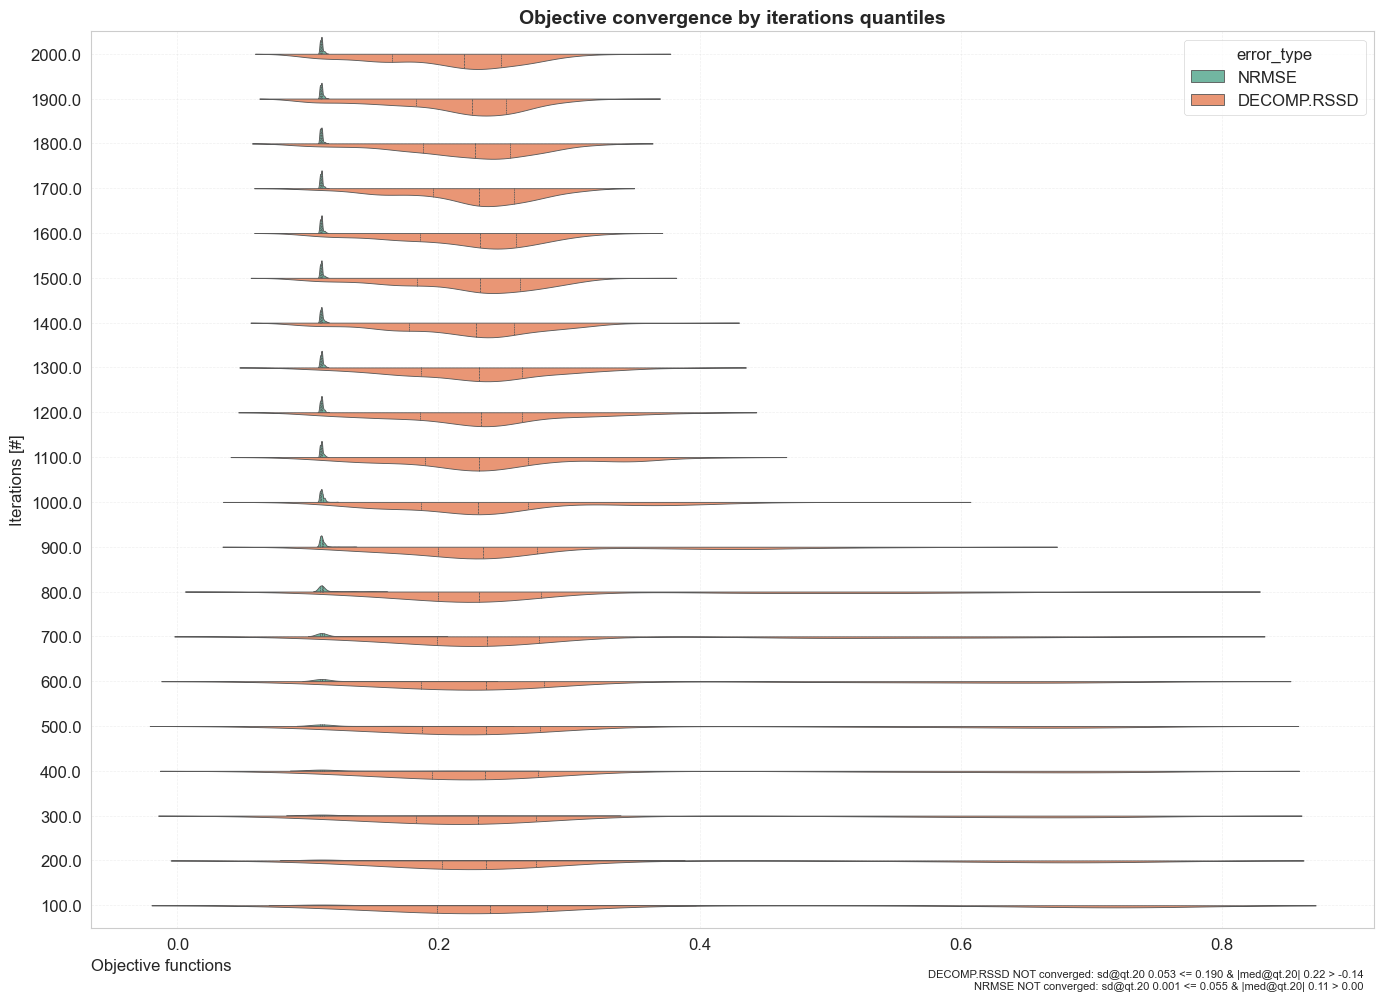

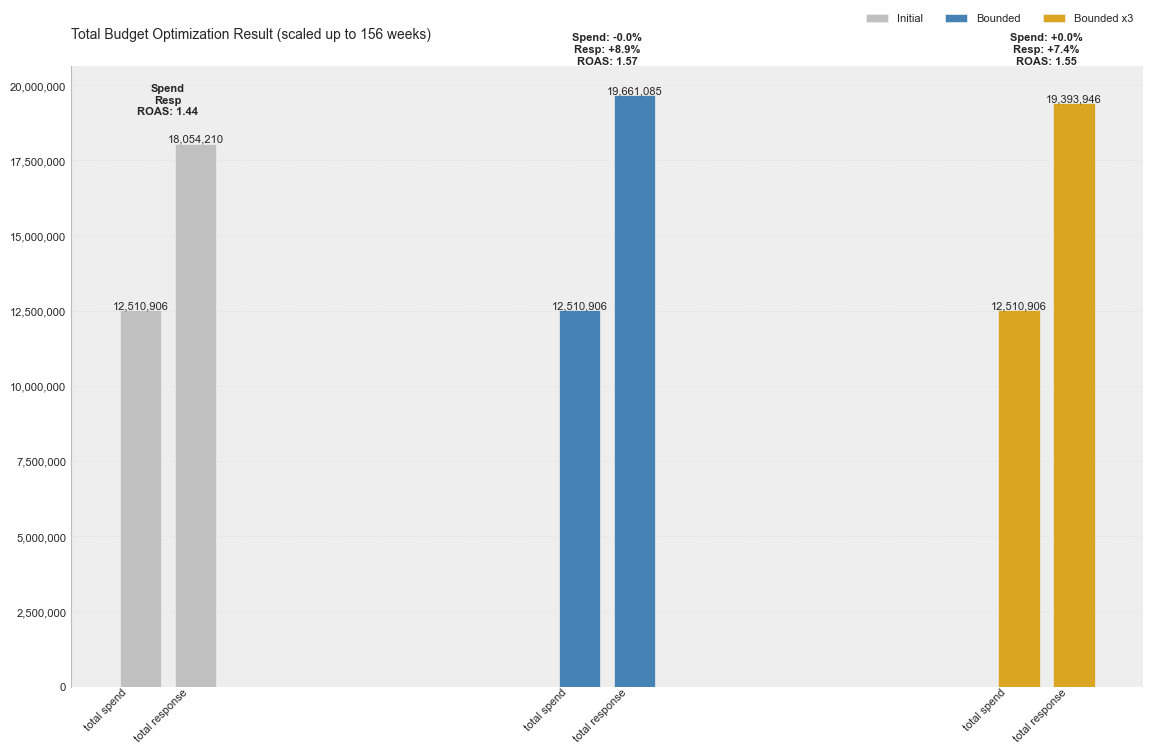

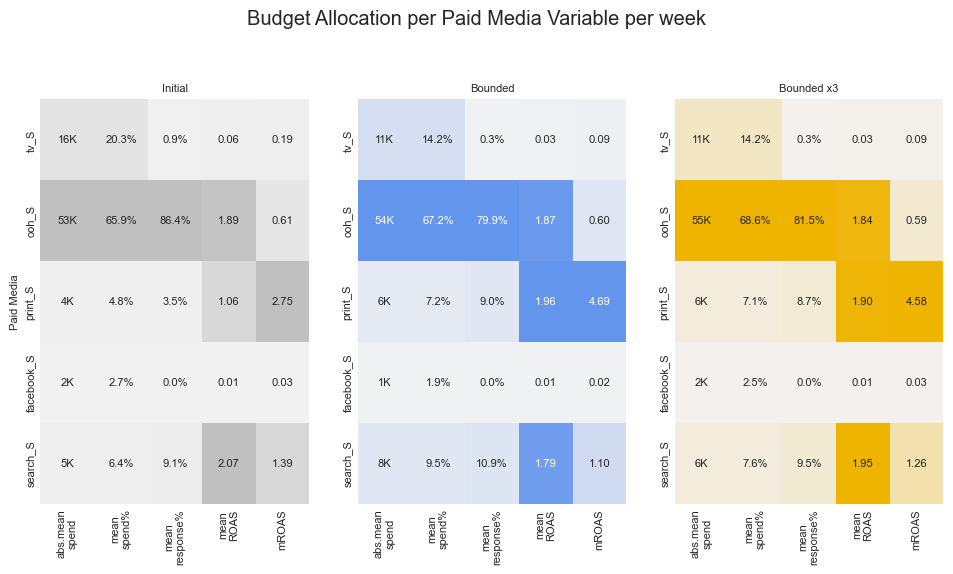

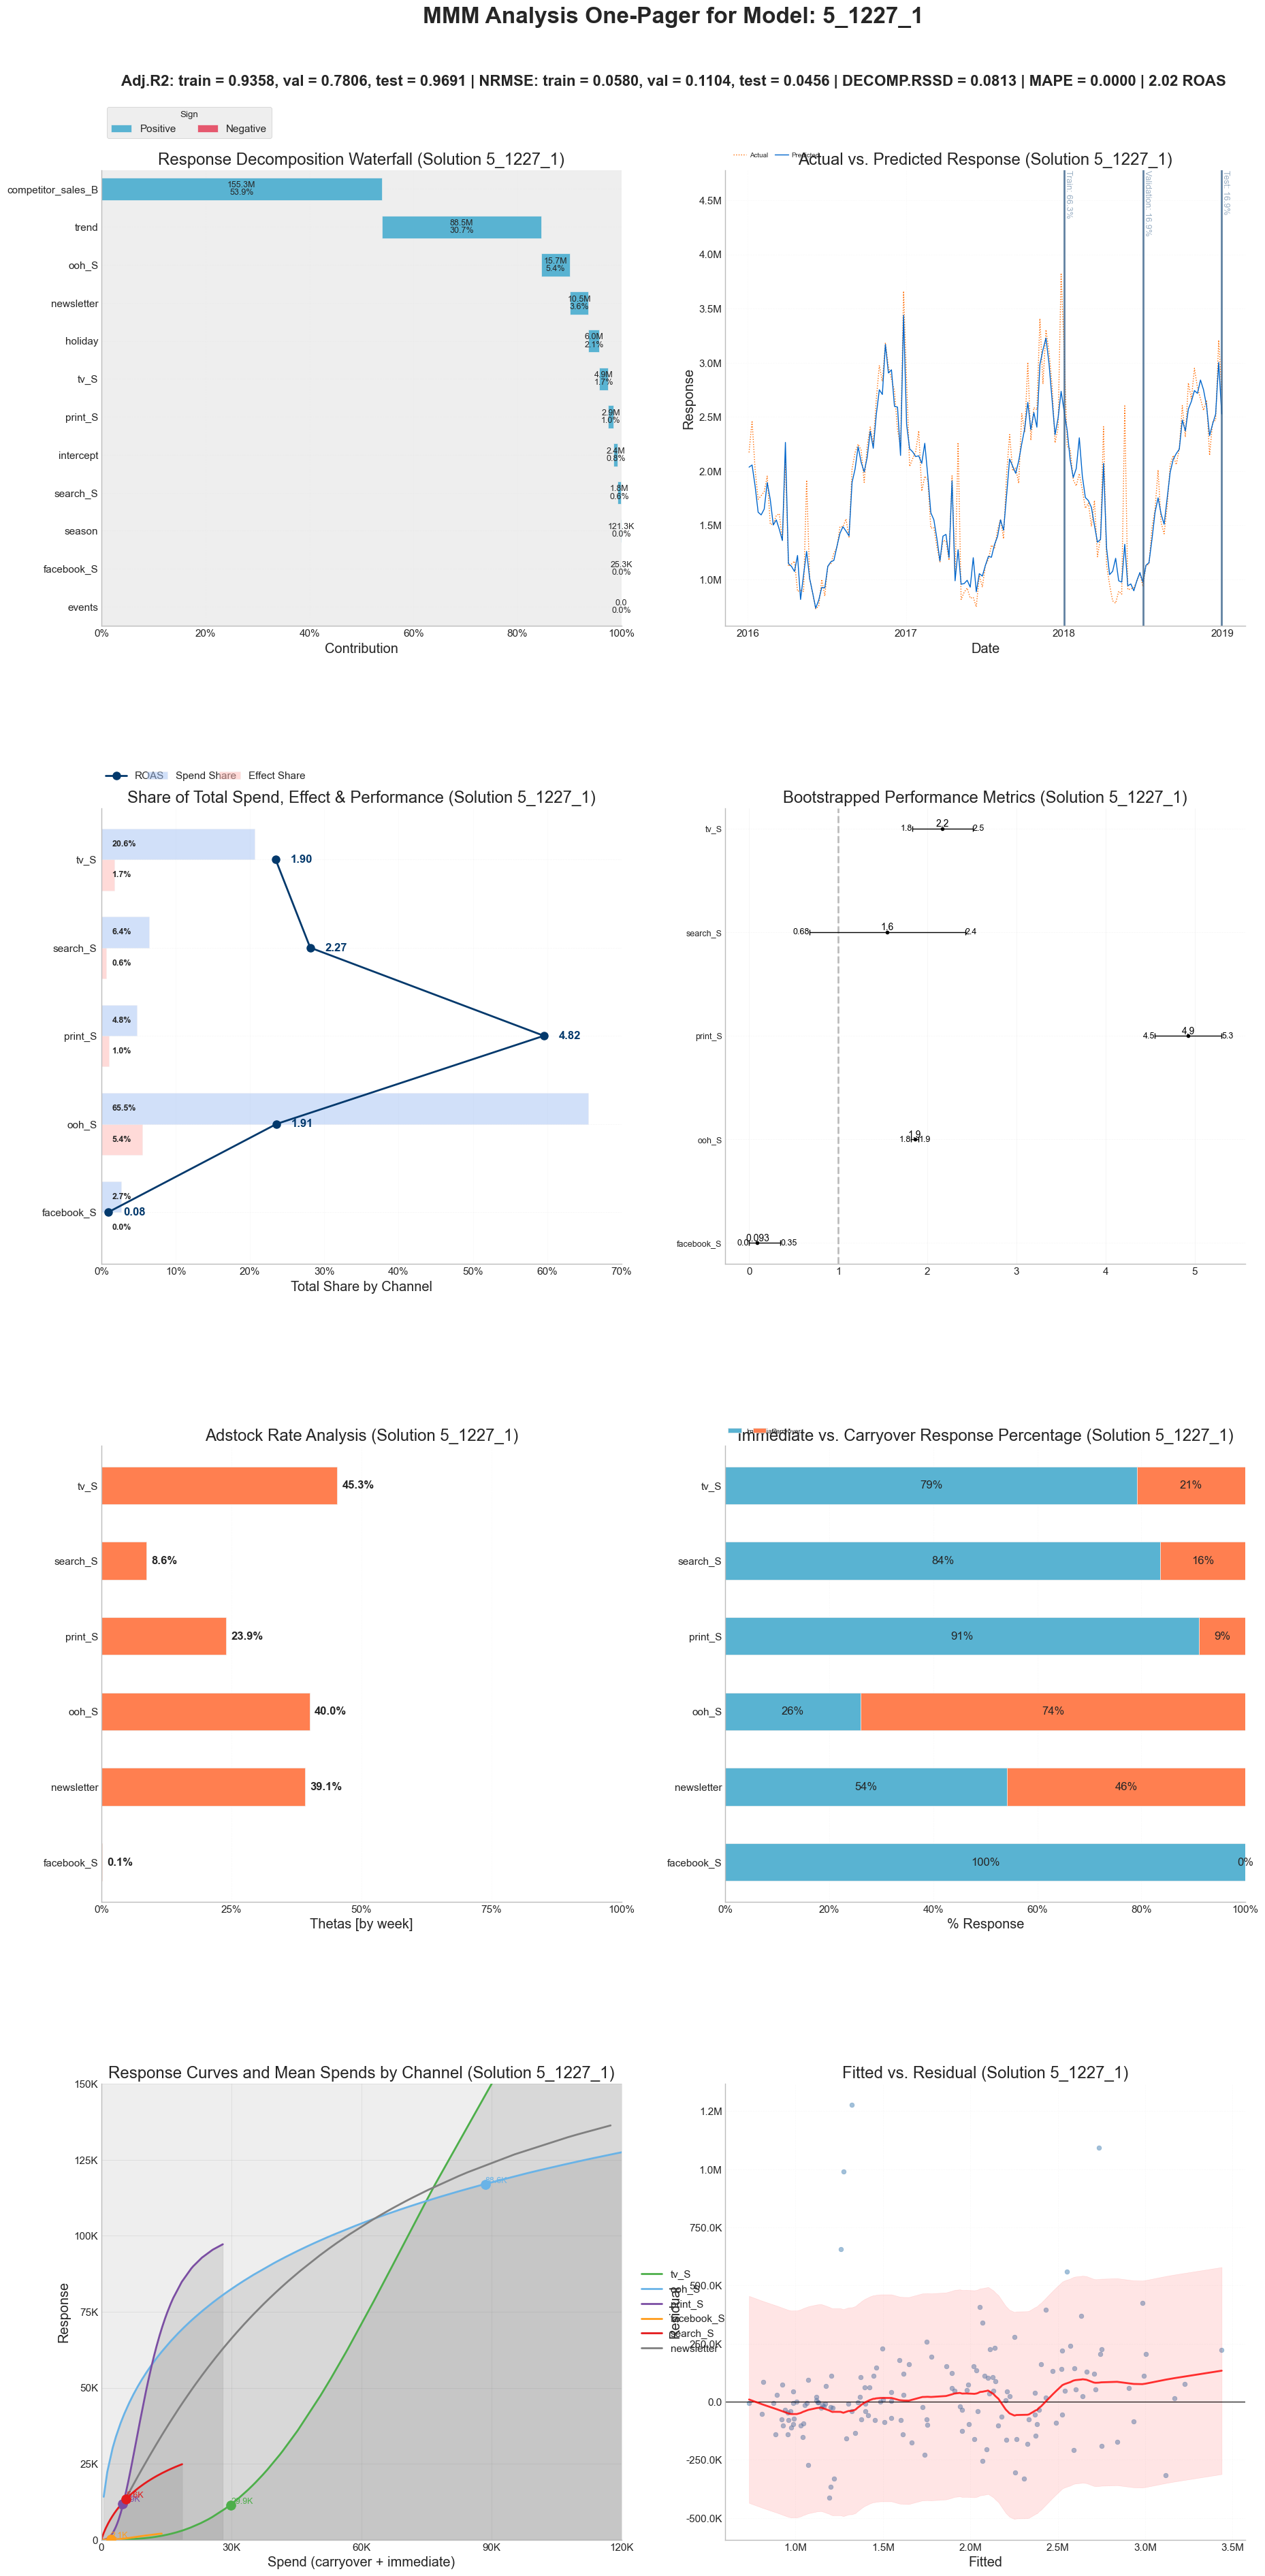

In [27]:
%matplotlib inline

from robyn.reporting.onepager_reporting import OnePager

OnePager(
    pareto_result, cluster_results, hyperparameters, mmm_data, holidays_data
).generate_one_pager(
    solution_ids=select_model,
    figsize=(20, 40),
    save_path="/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/debug/test",
)